# Initial Study: Examining Speculative Decoding Outputs

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer
HF_CACHE_LOCATION = "/data/shk148/models/opt/cache"
# To pre-cache all the OPT models easily (in parallel),
# use `../precache_opt_models.py HF_CACHE_LOCATION`

# For processing on GPU, we use PyTorch
# TensorFlow is also available, but Transformers' integration with PyTorch is more robust
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
# Things allocated on GPU is not cleared automaticaly.
# This can be problamatic when running the notebook multiple times,
# Or running it out-of-order.
# `clear_torch()` tries to free some space on the GPU.
import gc
def clear_torch():
    if "assistant_model" in globals() :
        global assistant_model
        del assistant_model
    if "target_model" in globals() :
        global target_model
        del target_model
    if "tokenizer" in globals():
        global tokenizer
        del tokenizer
    if "inputs" in globals():
        global inputs
        del inputs
    if "outputs" in globals():
        global outputs
        del outputs
    gc.collect()
    torch.cuda.empty_cache()
clear_torch()
torch.cuda.memory_reserved()

20971520

In [26]:
clear_torch()
# This is the Target LLM
checkpoint = "facebook/opt-6.7b"
# Load the model into the GPU
target_model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=HF_CACHE_LOCATION).cuda()
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=HF_CACHE_LOCATION)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
import time
def evaluate_llm(assistant_checkpoint):
    
    # Generate Output
    # Perform inference and measure latency
    num_iterations = 100  # Adjust this based on your requirements
    total_time = 0.0
    if assistant_checkpoint != "facebook/opt-6.7b":
        assistant_model = AutoModelForCausalLM.from_pretrained(assistant_checkpoint, cache_dir="/data/shk148/models/opt/cache").cuda()
        for _ in range(num_iterations):
            start_time = time.time()
            outputs = target_model.generate(inputs, assistant_model=assistant_model, do_sample=True,max_new_tokens=100)
            end_time = time.time()
            total_time += end_time - start_time
        del assistant_model
        torch.cuda.empty_cache()
    else:
        start_time = time.time()
        outputs = target_model.generate(inputs, do_sample=True,max_new_tokens=100)
        end_time = time.time()
        total_time += end_time - start_time
        # print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    return (total_time / num_iterations)

In [28]:
prompt = "A monolithic operating system differs"
inputs = tokenizer(prompt, return_tensors="pt").input_ids.cuda()

In [29]:
draft_models = [
	"facebook/opt-125m",
	"facebook/opt-350m",
	"facebook/opt-1.3b",
	"facebook/opt-2.7b",
    "facebook/opt-6.7b",
]

model_size = {
    "facebook/opt-125m": 125 * 1,
	"facebook/opt-350m": 350 * 1,
	"facebook/opt-1.3b": 1.3 * 1000,
	"facebook/opt-2.7b": 2.7 * 1000,
    "facebook/opt-6.7b": 6.7 * 1000
}

results = dict()
for model in draft_models:
    results[model_size[model]] = evaluate_llm(model)

In [30]:
import pandas as pd
df = pd.DataFrame(list(results.items()), columns=['Model', 'Time'])
df

,Model,Time
0,125.0,2.253015
1,350.0,2.619492
2,1300.0,2.286098
3,2700.0,3.164074
4,6700.0,3.592834


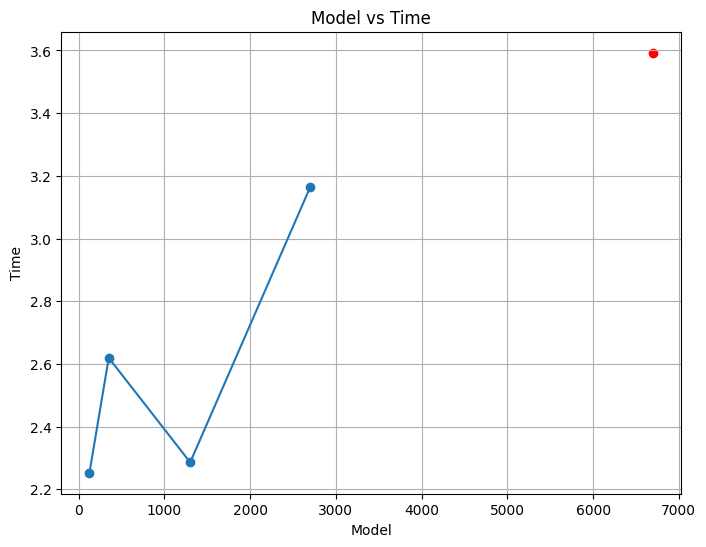

In [31]:
import matplotlib.pyplot as plt
no_spec = df.iloc[-1]
df = df.drop(df.index[-1])
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(df['Model'], df['Time'], marker='o', linestyle='-')
plt.scatter(no_spec['Model'], no_spec['Time'], color="red")
plt.title('Model vs Time')
plt.xlabel('Model')
plt.ylabel('Time')
plt.grid(True)
plt.show()
